In [367]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re
import math

In [368]:
# read file ktotal
df_ktotal = pd.read_csv('ktotal_contratos.csv')
# clean data
### format col names 
df_ktotal.columns = df_ktotal.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_ktotal = df_ktotal[df_ktotal['cct_contract_status_id']!=3]
df_ktotal = df_ktotal[['cct_ctl_id','cct_warranty_start_date', 'cct_contract_source', 'cct_plan_id']]
df_ktotal = df_ktotal.rename(columns={'cct_ctl_id': 'stockid', 'cct_warranty_start_date':'date_delivery', 
                                      'cct_contract_source':'source', 'cct_plan_id':'payment'})
### format date col
df_ktotal['date_delivery'] = pd.to_datetime(df_ktotal['date_delivery'])
### sort, filter by, and format stockid
df_ktotal = df_ktotal.sort_values('date_delivery', ascending=False)
df_ktotal = df_ktotal.drop_duplicates('stockid')
df_ktotal['stockid'] = df_ktotal['stockid'].astype(int)
# examine data
print(df_ktotal.shape)
df_ktotal.head()

(1378, 4)


,stockid,date_delivery,source,payment
615,24631,2020-11-27,2,1
633,25200,2020-11-27,2,1
1157,27028,2020-11-26,2,1
1070,24492,2020-11-26,3,0
1091,25653,2020-11-25,2,1


In [369]:
# read file kcapital
df_kcapital = pd.read_csv("kcapital_contratos.csv")
# clean data
### clean col names
df_kcapital.columns = df_kcapital.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### format date col
df_kcapital['dia_solicitud_aprobada'] = pd.to_datetime(df_kcapital['dia_solicitud_aprobada'], dayfirst=True)
### only include cars with kcapital
df_kcapital =  df_kcapital[df_kcapital['financiamiento_ganado'] == 'Yes']
### select and rename relevant cols
df_kcapital = df_kcapital[['inventory_item','dia_solicitud_aprobada']]
df_kcapital = df_kcapital.rename(columns={'dia_solicitud_aprobada': 'date_approved', 'inventory_item':'stockid'})
### format stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_kcapital['stockid'] = df_kcapital['stockid'].apply(extr_stockid)
df_kcapital['stockid'] = df_kcapital['stockid'].astype(int)
### sort and filter by stockid
df_kcapital = df_kcapital.sort_values('date_approved', ascending=False)
df_kcapital = df_kcapital.drop_duplicates('stockid')
# examine data
print(df_kcapital.shape)
df_kcapital.head()

(952, 2)


,stockid,date_approved
2455,24370,2020-11-19
1999,24333,2020-11-19
2454,22047,2020-11-19
2353,23546,2020-11-19
1835,21985,2020-11-19


In [370]:
# read file entregas
df_entregas = pd.read_csv("entregas.csv")
# clean data
### format col names
df_entregas.columns = df_entregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_entregas = df_entregas[['estimate_asociado','auto', 'fecha_de_entrega_agendada',
                           'hora', 'responsable_em_venta']]
df_entregas = df_entregas.rename(columns={'estimate_asociado': 'estimate', 'auto':'stockid', 
                                          'fecha_de_entrega_agendada':'date_delivery', 'hora':'hour',
                                          "responsable_em_venta":'salesperson'})
### format, filter by, and sort by date col
df_entregas['date_delivery'] = pd.to_datetime(df_entregas['date_delivery'],  dayfirst=True)
min_date = df_ktotal['date_delivery'].min()
df_entregas = df_entregas[df_entregas['date_delivery'] >= min_date]
df_entregas = df_entregas.sort_values('date_delivery', ascending=False)
### format and filter by stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_entregas['stockid'] = df_entregas['stockid'].apply(extr_stockid)
df_entregas = df_entregas.drop_duplicates('stockid')
### format estimate col
df_entregas['estimate'] = df_entregas['estimate'].str[10:]
# examine data
print(df_entregas.shape)
df_entregas.head()

(8160, 5)


,estimate,stockid,date_delivery,hour,salesperson
12546,2997693,25741,2020-12-03,11:00,Abril Contreras
12545,3121483,26712,2020-11-30,11:00,Abril Contreras
12544,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro
12543,3145465,26481,2020-11-28,11:00,Abril Contreras
12539,2859050,23299,2020-11-27,12:00,Maria Pina


In [371]:
# transorm entregas to include hub col
### read em file
ems = pd.read_csv('ems.csv')
### keep and rename relevant cols
ems = ems[['reponsable_em_venta', 'centro_del_em']]
ems = ems.rename(columns={'centro_del_em': 'hub', "reponsable_em_venta":'salesperson'})
### clean name col
for i in range(len(ems)):
    ems.iloc[i] = ems.iloc[i].str.strip()
### match salespeople with hub
hub = ["" for x in range(len(df_entregas))]
for i in range(len(df_entregas)):
    if df_entregas['salesperson'].iloc[i] in list(ems['salesperson'].values):
        indx = list(ems['salesperson'].values).index(df_entregas['salesperson'].iloc[i])
        hub[i] = ems['hub'].iloc[indx]
    else: hub[i] = 'Sin asignar'
### add hub col
df_entregas['hub'] = hub
print(sum(df_entregas['hub'] == 'Sin asignar'))
df_entregas.head()

2080


,estimate,stockid,date_delivery,hour,salesperson,hub
12546,2997693,25741,2020-12-03,11:00,Abril Contreras,Lerma
12545,3121483,26712,2020-11-30,11:00,Abril Contreras,Lerma
12544,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro,San Angel
12543,3145465,26481,2020-11-28,11:00,Abril Contreras,Lerma
12539,2859050,23299,2020-11-27,12:00,Maria Pina,Santa Fe


In [372]:
# transform entregas to include ktotal and tradein cols
ktotal = np.zeros(len(df_entregas), dtype=int)
tradein = np.zeros(len(df_entregas), dtype=int)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_ktotal['stockid'].values):
        ktotal[i] = 1
        indx = list(df_ktotal['stockid'].values).index(int(df_entregas['stockid'].iloc[i]))
        if(df_ktotal['source'].iloc[indx]==3): tradein[i] = 1                                                     
df_entregas['ktotal'] = ktotal
df_entregas['tradein'] = tradein
print(sum(df_entregas['ktotal'] == 1))
print(sum(df_entregas['tradein'] == 1))
df_entregas.head()

1317
300


,estimate,stockid,date_delivery,hour,salesperson,hub,ktotal,tradein
12546,2997693,25741,2020-12-03,11:00,Abril Contreras,Lerma,0,0
12545,3121483,26712,2020-11-30,11:00,Abril Contreras,Lerma,0,0
12544,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro,San Angel,0,0
12543,3145465,26481,2020-11-28,11:00,Abril Contreras,Lerma,0,0
12539,2859050,23299,2020-11-27,12:00,Maria Pina,Santa Fe,0,0


In [373]:
# transform entregas to include kcapital col
kcapital = np.zeros(len(df_entregas), dtype=int)
for i in range(len(df_entregas)):
    if (int(df_entregas['stockid'].iloc[i]) in df_kcapital['stockid'].values):
        kcapital[i] = 1
df_entregas['kcapital'] = kcapital
print(sum(df_entregas['kcapital'] == 1))
df_entregas.head()

865


,estimate,stockid,date_delivery,hour,salesperson,hub,ktotal,tradein,kcapital
12546,2997693,25741,2020-12-03,11:00,Abril Contreras,Lerma,0,0,0
12545,3121483,26712,2020-11-30,11:00,Abril Contreras,Lerma,0,0,1
12544,3190207,20620,2020-11-28,14:00,Herys de Jesús Navarro Castro,San Angel,0,0,0
12543,3145465,26481,2020-11-28,11:00,Abril Contreras,Lerma,0,0,0
12539,2859050,23299,2020-11-27,12:00,Maria Pina,Santa Fe,0,0,1


In [427]:
# calculations
# cols 1-2
### find last 15 days
ayer = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=1))
hace_quince = pd.to_datetime(datetime.date(datetime.now())-timedelta(days=15))
curr_days = pd.date_range(hace_quince, periods=15)
print(curr_days)
### filter data for curr day
df_curr_day = df_entregas[df_entregas['date_delivery'].isin(curr_days)]
### initialize dics
daily_entregas = {}
daily_ktotal = {}
daily_ti = {}
### find num of entregas, ktotal, and tradeins
for hub, frame in df_curr_day.groupby(['hub']):
    if (hub == 'Sin asignar'): 
        print(frame)
        print('\n')
    daily_entregas[hub] = len(frame)
    daily_ktotal[hub] = sum(frame['ktotal']==1)
    daily_ti[hub] = sum(frame['tradein']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas.keys()):
    daily_entregas.pop('Sin asignar')
x_entr = daily_entregas.keys()
y_entr = [float(i) for i in daily_entregas.values()] 
### 1: set x and y values: ktotal 
if ('Sin asignar' in daily_ktotal.keys()):
    daily_ktotal.pop('Sin asignar')
x_ktot = daily_ktotal.keys()
y_ktot = [float(i) for i in daily_ktotal.values()] 
y_ktot_pr = [i / j for i, j in zip(y_ktot, y_entr)]
### 2: set x and y values: tradeins
if ('Sin asignar' in daily_ti.keys()):
    daily_ti.pop('Sin asignar')
x_ti = daily_ti.keys()
y_ti = [float(i) for i in daily_ti.values()] 
y_ti_pr = [i / j for i, j in zip(y_ti, y_entr)]

DatetimeIndex(['2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16',
               '2020-11-17', '2020-11-18', '2020-11-19'],
              dtype='datetime64[ns]', freq='D')
      estimate stockid date_delivery   hour  \
12259  3095285   25612    2020-11-19  11:00   
12349  3186999   24769    2020-11-19  19:30   
12309  3115564   24992    2020-11-19  15:00   
12147  3145882   15674    2020-11-17  13:00   
12083  3184986   24956    2020-11-16  13:30   
12109  3197190   22681    2020-11-16  18:30   
12061  3184035   22979    2020-11-15  21:00   
11972  2996029   22207    2020-11-14  13:30   
11876  2964060   26296    2020-11-12  19:00   
11662  2928717   21506    2020-11-08  11:30   
11619  2818103   22256    2020-11-07  11:00   
11617  2919169   20585    2020-11-07  11:00   
11616  2921535   23656    2020-11-07  11:00   
11658  2984281   22462 

In [428]:
# col 3
### exclude trade-ins
df_curr_day_noti = df_curr_day[df_curr_day['tradein']==0]
### initialize dics
daily_entregas_noti = {}
daily_kcap_noti = {}
### find num of entregas, kcapital
for hub, frame in df_curr_day_noti.groupby(['hub']):
    daily_entregas_noti[hub] = len(frame)
    daily_kcap_noti[hub] = sum(frame['kcapital']==1)
### set x and y values: entregas 
daily_entregas_noti.pop('Sin asignar')
x_entr_noti = daily_entregas_noti.keys()
y_entr_noti = [float(i) for i in daily_entregas_noti.values()] 
### 3: set x and y values: kcapital 
daily_kcap_noti.pop('Sin asignar')
x_kcap_noti = daily_kcap_noti.keys()
y_kcap_noti = [float(i) for i in daily_kcap_noti.values()] 
y_kcap_noti_pr = [i / j for i, j in zip(y_kcap_noti, y_entr_noti)]

In [442]:
# col 4
### consider only kcapital (excluding trade-ins)
df_curr_day_kcap = df_curr_day[(df_curr_day['kcapital']==1) & (df_curr_day['tradein']==0)]
### initialize dics
daily_entregas_kcap = {}
daily_ktot_kcap = {}
### find num of entregas, kcapital
for hub, frame in df_curr_day_kcap.groupby(['hub']):
    daily_entregas_kcap[hub] = len(frame)
    daily_ktot_kcap[hub] = sum(frame['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in daily_entregas_kcap.keys()):
    daily_entregas_kcap.pop('Sin asignar')
x_entr_kcap = daily_entregas_kcap.keys()
y_entr_kcap = [float(i) for i in daily_entregas_kcap.values()] 
### set x and y values: kcapital 
if ('Sin asignar' in daily_ktot_kcap.keys()):
    daily_ktot_kcap.pop('Sin asignar')
x_ktot_kcap = daily_ktot_kcap.keys()
y_ktot_kcap = [float(i) for i in daily_ktot_kcap.values()] 
y_ktot_kcap_pr = [i / j for i, j in zip(y_ktot_kcap, y_entr_kcap)]

In [443]:
# col 5
### exclude trade-ins and kcapital
df_noti_nkcap = df_curr_day[(df_curr_day['tradein']==0) & (df_curr_day['kcapital']==0)]
### initialize dics
noti_nkcap = {}
ktot_noti_nkcap = {}
### find num of entregas, ktotal
for hub, frame in df_noti_nkcap.groupby(['hub']):
    noti_nkcap[hub] = len(frame)
    ktot_noti_nkcap[hub] = sum(frame['ktotal']==1)
### set x and y values: entregas 
if ('Sin asignar' in noti_nkcap.keys()):
    noti_nkcap.pop('Sin asignar')
x_enoti_nkcap = noti_nkcap.keys()
y_enoti_nkcap = [float(i) for i in noti_nkcap.values()] 
### set x and y values: ktotal 
if ('Sin asignar' in ktot_noti_nkcap.keys()):
    ktot_noti_nkcap.pop('Sin asignar')
x_ktot_ntikc = ktot_noti_nkcap.keys()
y_ktot_ntikc = [float(i) for i in ktot_noti_nkcap.values()] 
y_ktot_ntikc_pr = [i / j for i, j in zip(y_ktot_ntikc, y_enoti_nkcap)]

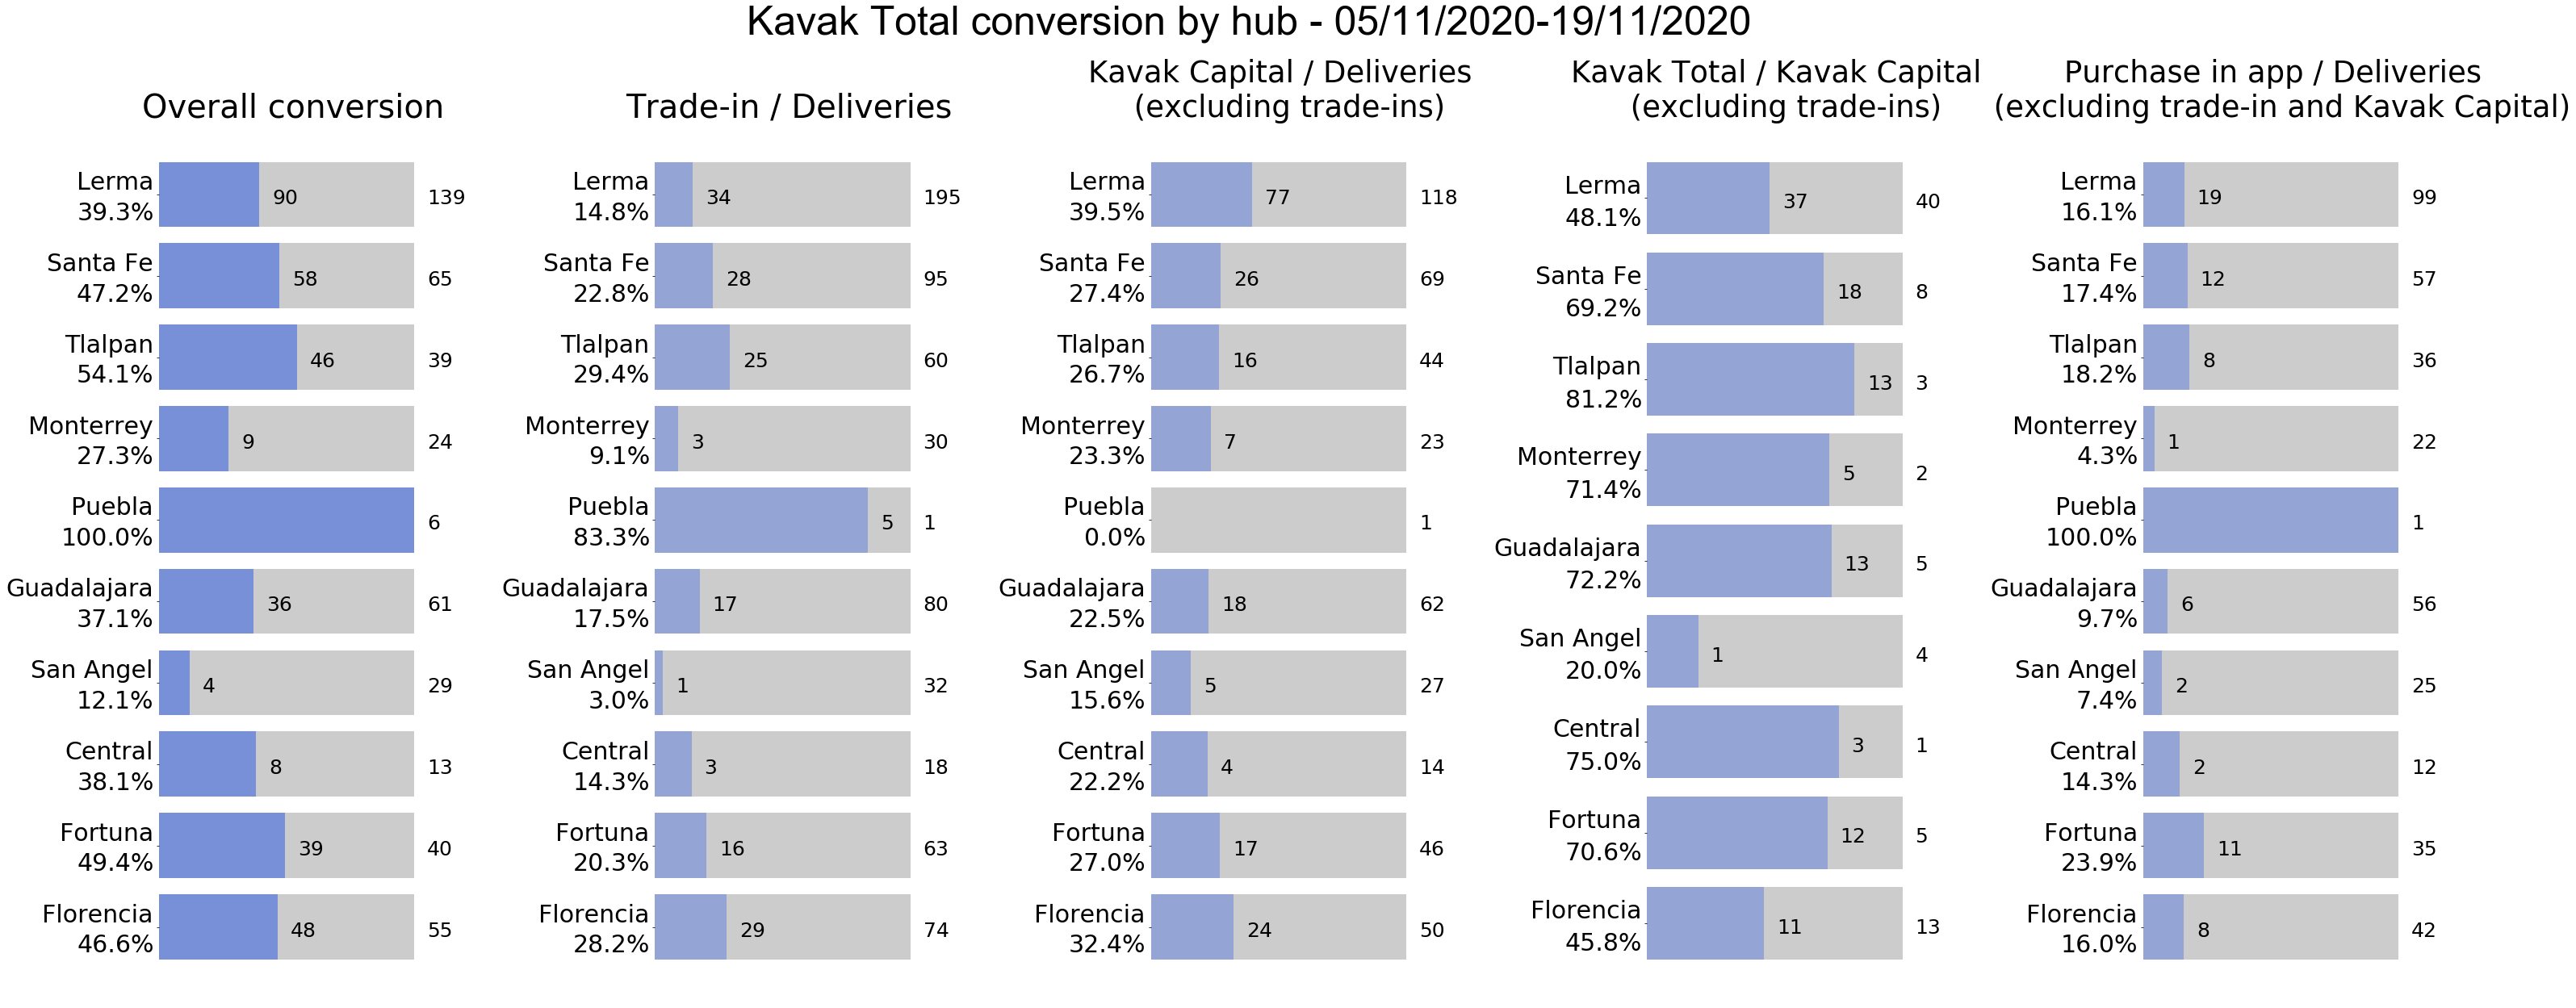

In [444]:
# plot figure with 5 cols
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(50)
### 1
bar1g = ax1.barh(x_ktot, [1] * len(x_ktot), alpha=.4, color="gray")
bar1 = ax1.barh(x_ktot, y_ktot_pr, alpha=.6, color="royalblue")
ax1.set_title('Overall conversion', fontsize=40)
ax1.set_yticklabels(x_ktot, va='bottom')
### 2
bar2g = ax2.barh(x_ti, [1] * len(x_ti), alpha=.4, color="gray")
bar2 = ax2.barh(x_ti, y_ti_pr, alpha=.4, color="royalblue")
ax2.set_title('Trade-in / Deliveries', fontsize=40)
ax2.set_yticklabels(x_ti, va='bottom')
### 3
bar3g = ax3.barh(x_kcap_noti, [1] * len(x_kcap_noti), alpha=.4, color="gray")
bar3 = ax3.barh(x_kcap_noti, y_kcap_noti_pr, alpha=.4, color="royalblue")
ax3.set_title('Kavak Capital / Deliveries \n (excluding trade-ins)', fontsize=37)
ax3.set_yticklabels(x_kcap_noti, va='bottom')
### 4
bar4g = ax4.barh(x_ktot_kcap, [1] * len(x_ktot_kcap), alpha=.4, color="gray")
bar4 = ax4.barh(x_ktot_kcap, y_ktot_kcap_pr, alpha=.4, color="royalblue")
ax4.set_title('Kavak Total / Kavak Capital \n (excluding trade-ins)', fontsize=37)
ax4.set_yticklabels(x_ktot_kcap, va='bottom')
### 5
bar5g = ax5.barh(x_ktot_ntikc, [1] * len(x_ktot_ntikc), alpha=.4, color="gray")
bar5 = ax5.barh(x_ktot_ntikc, y_ktot_ntikc_pr, alpha=.4, color="royalblue")
ax5.set_title('Purchase in app / Deliveries \n (excluding trade-in and Kavak Capital)', fontsize=37)
ax5.set_yticklabels(x_ktot_ntikc, va='bottom')
# format axes, title, and labels
### axes
for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
plt.rc('ytick', labelsize=30) 
plt.subplots_adjust(wspace = 0.85)
### title
titlestr = ('Kavak Total conversion by hub - ' + hace_quince.strftime('%d/%m/%Y') + '-' + 
           ayer.strftime('%d/%m/%Y'))
fig.suptitle(titlestr, fontsize=50, fontname="Arial");
### labels
##### 1
for idx,rect in enumerate(bar1):
    if (y_ktot[idx] != 0):
        ax1.text(y_ktot_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ktot[idx]) != 0):
        ax1.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]-y_ktot[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax1.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_pr[idx]), fontsize=30,
            ha='right', va='center', rotation=0)
##### 2
for idx,rect in enumerate(bar2):
    if (y_ti[idx] != 0):
        ax2.text(y_ti_pr[idx]+.05, rect.get_y()+.35,
            int(y_ti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr[idx]-y_ti[idx]) != 0):
        ax2.text(1+.05, rect.get_y()+.35,
            int(y_entr[idx]-y_ti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax2.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ti_pr[idx]), fontsize=30,
            ha='right', va='center', rotation=0) 
##### 3
for idx,rect in enumerate(bar3):
    if (y_kcap_noti[idx] != 0):
        ax3.text(y_kcap_noti_pr[idx]+.05, rect.get_y()+.35,
            int(y_kcap_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_noti[idx]-y_kcap_noti[idx]) != 0):
        ax3.text(1+.05, rect.get_y()+.35,
            int(y_entr_noti[idx]-y_kcap_noti[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax3.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_kcap_noti_pr[idx]), fontsize=30,
            ha='right', va='center', rotation=0)
##### 4
for idx,rect in enumerate(bar4):
    if (y_ktot_kcap[idx] != 0):
        ax4.text(y_ktot_kcap_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_entr_kcap[idx]-y_ktot_kcap[idx]) != 0):
        ax4.text(1+.05, rect.get_y()+.35,
            int(y_entr_kcap[idx]-y_ktot_kcap[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax4.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_kcap_pr[idx]), fontsize=30,
            ha='right', va='center', rotation=0)
##### 5
for idx,rect in enumerate(bar5):
    if (y_ktot_ntikc[idx] != 0):
        ax5.text(y_ktot_ntikc_pr[idx]+.05, rect.get_y()+.35,
            int(y_ktot_ntikc[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    if ((y_enoti_nkcap[idx]-y_ktot_ntikc[idx]) != 0):
        ax5.text(1+.05, rect.get_y()+.35,
            int(y_enoti_nkcap[idx]-y_ktot_ntikc[idx]), fontsize=25,
            ha='left', va='center', rotation=0)
    ax5.text(rect.get_x()-.02, rect.get_y()+.17,
            "{:.1%}".format(y_ktot_ntikc_pr[idx]), fontsize=30,
            ha='right', va='center', rotation=0)
# save fig
plt.savefig('daily_hub_performance.png') 

In [335]:
# deliveries per hour
### find curr day, month, and year
curr_day = datetime.date(datetime.now()).day
curr_month = datetime.date(datetime.now()).month
curr_year = datetime.date(datetime.now()).year
print("Promedio de entregas por hora MTD (" + str(curr_day) + "-" + str(curr_month) + "-" + str(curr_year) + ")")
print("\n")
### filter data by curr month + year
df_month = df_entregas[(df_entregas['date_delivery'].dt.month == curr_month) &
                      (df_entregas['date_delivery'].dt.year == curr_year) &
                      (df_entregas['date_delivery'].dt.day <= curr_day)]
### create day col
df_month['day'] = df_month['date_delivery'].dt.day
### find hourly delivery averages for each hub
for hub, frame in df_month.groupby(['hub']):
    if(hub=='Sin asignar'): continue
    print(hub)
    for hour, frame_hour in frame.groupby(['hour']):
        sumh = float(len(frame_hour))
        days = float(len(set(frame_hour['day'])))
        avg = round(float(sumh/days), 2)
        if(avg != 1): print(hour + ": " + str(avg)) 
        else: continue
    print("\n")

Promedio de entregas por hora MTD (20-11-2020)




/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Central
12:00: 1.5


Constituyentes


Florencia
10:00: 1.13
12:00: 1.91
15:00: 1.13
16:00: 1.33
16:15: 1.25
16:30: 1.33
17:00: 1.1
18:30: 1.5


Fortuna
10:00: 1.4
11:00: 1.2
12:00: 1.3
13:00: 1.4
14:00: 1.33
15:00: 1.2
16:00: 1.43
17:00: 1.25
20:00: 1.33


Guadalajara
10:00: 1.75
11:00: 1.36
12:00: 1.6
14:00: 1.14
15:00: 1.33
16:00: 1.38
17:00: 1.29
17:30: 1.5
18:00: 1.33
18:30: 1.5


Lerma
10:00: 1.45
11:00: 2.13
12:00: 2.69
13:00: 1.85
14:00: 1.54
15:00: 1.79
16:00: 2.0
17:00: 1.77
17:30: 1.14
18:00: 1.22
19:00: 1.4
20:00: 1.2
22:00: 1.67
9:00: 2.0
9:30: 1.25


Monterrey
10:00: 1.17
10:30: 2.0
11:00: 1.5
12:00: 2.0
14:30: 1.33
17:00: 1.25
17:30: 2.0


Puebla
12:00: 2.0


San Angel
14:00: 1.5
15:00: 1.5
17:00: 1.25


Santa Fe
10:00: 1.17
11:00: 1.57
12:00: 1.45
13:00: 1.5
14:00: 1.5
15:00: 1.6
16:00: 1.54
17:00: 1.57


Tlalpan
16:00: 1.33
17:00: 1.4
17:30: 1.2
18:00: 2.0


